# Task 4 — Portfolio Optimization with MPT
This notebook builds an optimized portfolio using the **TSLA forecast** (Task 2 model output) and **historical data** for BND and SPY. It computes expected returns, the covariance matrix, the efficient frontier, and recommends an optimal portfolio.

## 1. Load Data and Define Expected Returns
Load TSLA, BND, and SPY prices. Use the **TSLA forecast** from the Task 2 model as TSLA’s expected return, and **historical average daily returns (annualized)** for BND and SPY.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import joblib
from pathlib import Path
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = Path('..') / 'data' / 'processed' / 'financial_data_clean.csv'
data = pd.read_csv(data_path, index_col='Date', parse_dates=True)

required_cols = ['TSLA', 'BND', 'SPY']
missing_cols = [c for c in required_cols if c not in data.columns]
if missing_cols:
    raise ValueError(f"Missing columns in data: {missing_cols}")

prices = data[required_cols].dropna()

# Load best-performing TSLA model from Task 2
model_path = Path('..') / 'models' / 'arima_model_tsla.pkl'
model_arima_res = joblib.load(model_path)

# Forecast TSLA prices for ~12 months (252 business days)
forecast_horizon = 252
forecast_result = model_arima_res.get_forecast(steps=forecast_horizon)
tsla_forecast = forecast_result.predicted_mean

# Convert forecasted prices to forecasted daily returns
tsla_forecast_returns = tsla_forecast.pct_change().dropna()
tsla_expected_annual_return = (1 + tsla_forecast_returns.mean()) ** 252 - 1

# Historical daily returns for BND & SPY (annualized)
daily_returns = prices.pct_change().dropna()
bnd_expected_annual_return = (1 + daily_returns['BND'].mean()) ** 252 - 1
spy_expected_annual_return = (1 + daily_returns['SPY'].mean()) ** 252 - 1

expected_returns = pd.Series({
    'TSLA': tsla_expected_annual_return,
    'BND': bnd_expected_annual_return,
    'SPY': spy_expected_annual_return
})

expected_returns

c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TSLA    0.000000
BND     0.020643
SPY     0.153510
dtype: float64

## 2. Compute Daily Returns and Covariance Matrix
Compute daily returns and the **annualized covariance matrix** used to estimate portfolio risk.

In [2]:
daily_returns = prices.pct_change().dropna()
cov_matrix = daily_returns.cov() * 252  # annualized covariance
cov_matrix

,TSLA,BND,SPY
TSLA,0.332840,0.001667,0.050172
BND,0.001667,0.002869,0.001013
SPY,0.050172,0.001013,0.031569


## 3. Visualize Covariance Matrix Heatmap
Inspect relationships between assets using a covariance heatmap.

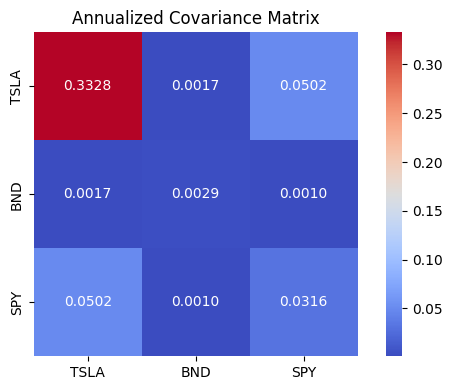

In [3]:
plt.figure(figsize=(6, 4))
sns.heatmap(cov_matrix, annot=True, fmt='.4f', cmap='coolwarm', square=True)
plt.title('Annualized Covariance Matrix')
plt.tight_layout()
plt.show()

## 4. Optimize Portfolios and Generate Efficient Frontier
Use numerical optimization to estimate optimal portfolios and generate the efficient frontier.

In [4]:
assets = expected_returns.index.tolist()
mu = expected_returns.values
cov = cov_matrix.values
rf = 0.02

def portfolio_performance(weights):
    ret = np.dot(weights, mu)
    vol = np.sqrt(weights.T @ cov @ weights)
    sharpe = (ret - rf) / vol if vol > 0 else np.nan
    return ret, vol, sharpe

# Constraints and bounds
n_assets = len(assets)
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)

# Minimum volatility portfolio
def portfolio_volatility(weights):
    return portfolio_performance(weights)[1]

init_w = np.array([1 / n_assets] * n_assets)
min_vol = minimize(portfolio_volatility, init_w, method='SLSQP', bounds=bounds, constraints=constraints)
min_vol_w = min_vol.x

# Maximum Sharpe ratio portfolio
def negative_sharpe(weights):
    return -portfolio_performance(weights)[2]

max_sharpe = minimize(negative_sharpe, init_w, method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_w = max_sharpe.x

# Monte Carlo simulation for efficient frontier
n_portfolios = 10000
all_weights = np.zeros((n_portfolios, n_assets))
ret_arr = np.zeros(n_portfolios)
vol_arr = np.zeros(n_portfolios)
sharpe_arr = np.zeros(n_portfolios)

for i in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    all_weights[i, :] = weights
    r, v, s = portfolio_performance(weights)
    ret_arr[i] = r
    vol_arr[i] = v
    sharpe_arr[i] = s

## 5. Identify Maximum Sharpe and Minimum Volatility Portfolios
Compute portfolio metrics for the tangency (maximum Sharpe) and minimum volatility portfolios.

In [5]:
min_vol_ret, min_vol_vol, min_vol_sharpe = portfolio_performance(min_vol_w)
max_sharpe_ret, max_sharpe_vol, max_sharpe_sharpe = portfolio_performance(max_sharpe_w)

min_vol_port = pd.Series(min_vol_w, index=assets, name='Min Vol Weights')
max_sharpe_port = pd.Series(max_sharpe_w, index=assets, name='Max Sharpe Weights')

min_vol_port, max_sharpe_port

(TSLA    6.071532e-18
 BND     9.428650e-01
 SPY     5.713500e-02
 Name: Min Vol Weights, dtype: float64,
 TSLA    0.000000e+00
 BND     2.630578e-14
 SPY     1.000000e+00
 Name: Max Sharpe Weights, dtype: float64)

## 6. Plot Efficient Frontier with Key Portfolios Marked
Plot the efficient frontier (risk vs. return) and mark the max Sharpe and minimum volatility portfolios.

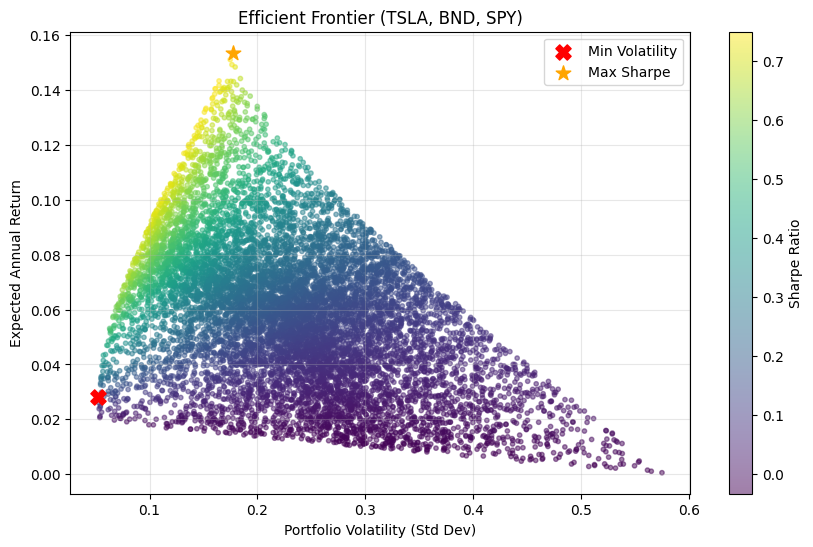

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# Mark key portfolios
plt.scatter(min_vol_vol, min_vol_ret, color='red', s=120, marker='X', label='Min Volatility')
plt.scatter(max_sharpe_vol, max_sharpe_ret, color='orange', s=120, marker='*', label='Max Sharpe')

plt.title('Efficient Frontier (TSLA, BND, SPY)')
plt.xlabel('Portfolio Volatility (Std Dev)')
plt.ylabel('Expected Annual Return')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 7. Summarize Recommended Portfolio Weights and Metrics
Select the recommended portfolio and report weights, expected return, volatility, and Sharpe ratio.

In [7]:
# Choose recommended portfolio (max Sharpe by default)
recommended = 'Max Sharpe'
rec_w = max_sharpe_w
rec_ret, rec_vol, rec_sharpe = max_sharpe_ret, max_sharpe_vol, max_sharpe_sharpe

summary = pd.DataFrame({
    'Weight': rec_w
}, index=assets)

metrics = pd.Series({
    'Expected Annual Return': rec_ret,
    'Expected Volatility': rec_vol,
    'Sharpe Ratio': rec_sharpe
})

summary, metrics

(            Weight
 TSLA  0.000000e+00
 BND   2.630578e-14
 SPY   1.000000e+00,
 Expected Annual Return    0.153510
 Expected Volatility       0.177676
 Sharpe Ratio              0.751425
 dtype: float64)

## 8. Portfolio Selection Justification
The recommended portfolio is the **Maximum Sharpe Ratio (tangency) portfolio** because it provides the strongest risk‑adjusted return based on the TSLA forecast and the historical behavior of BND and SPY. This choice balances expected performance with volatility, which is especially important when forecast uncertainty grows over a 12‑month horizon. If a lower‑risk profile is preferred, the minimum volatility portfolio is the conservative alternative, but it typically sacrifices expected return. Given the objective to optimize return for a given level of risk, the max‑Sharpe allocation is the most defensible recommendation.